Ustawienia wyświetlania:

In [14]:
# encoding: utf-8
% matplotlib inline
import matplotlib

matplotlib.rcParams['figure.figsize'] = (7,6)#(10, 7)
matplotlib.rcParams.update({'font.family': 'Arial'})
matplotlib.rcParams.update({'font.size': 10})

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Importy:

In [15]:
import numpy as np
import pylab as py
import scipy.signal as ss

Definicje potrzebnych funkcji:

In [34]:
def czas(T = 1.0, Fs = 128.0):
    dt = 1.0/Fs
    t = np.arange(0,T,dt)
    return t
 
def gabor(t0 = 0.5, sigma = 0.1, T = 1.0, f=10, phi = 0, Fs = 128.0):
    t = czas(T,Fs)
    s = np.exp(-((t-t0)/(sigma))**2/2) * np.cos(2*np.pi*f*(t-t0) + phi)
    return s
 
def sin(f = 10.0, T = 1.0, Fs = 128.0, phi =0 ):
    '''sin o zadanej cz?sto?ci (w Hz), d?ugo?ci, fazie i cz?sto?ci próbkowania
    Domy?lnie wytwarzany jest sygna? reprezentuj?cy 
    1 sekund? sinusa o cz?sto?ci 1Hz i zerowej fazie próbkowanego 128 Hz
    '''
    t = czas(T,Fs)
    s = np.sin(2*np.pi*f*t + phi)
    return s
 
def chirp(f0,fk,T,Fs):
    '''
    f0 - częstość początkowa
    fk - częstość końcowa
    T - długość trwania
    Fs  -częstość próbkowania
    '''
    t = czas(T,Fs)
    f  = f0 + (fk-f0)/2.0/(T)*t
    s  = np.cos(2*np.pi*t*f)
    return s

def TFRPlot(TFR, t_mapy, f_mapy, sig, Fs=128,title =''):
    '''
    Funkcja do rysowania map czas-częstość z sygnałem zaprezentowanym poniżej
    TFR - mapa czas-częstość (time-freqyency representation
    t_mapy, f_mapy - wektory reprezentujące osie czasu i częstości
    sig - sygnał do wyrysowania pod mapą (np. ten, z którego powstała mapa)
    Fs - częstość próbkowania sygnału 
    title - tytuł do wyświetlenia ponad mapą
    '''
    df = f_mapy[1]-f_mapy[0]
    dt = t_mapy[1]-t_mapy[0]
    t = np.arange(0,len(sig))/Fs
    py.figure(figsize=(10,10))
    sygAxes = py.axes([0.05, 0.05, 0.8, 0.1])
    tfAxes = py.axes([0.05, 0.15, 0.8, 0.8])
    sygAxes.plot(t,sig)
    py.xlim((t_mapy.min(), t_mapy.max()))
    #py.setp(sygAxes, yticklabels=[])
    tfAxes.imshow(TFR,aspect='auto',origin='lower',interpolation='nearest', 
                  extent=(t_mapy.min()-dt/2,t_mapy.max()+dt/2,f_mapy.min()-df/2,f_mapy.max()+df/2))
    py.setp(tfAxes,xticklabels=[])
    py.title(title)
    py.show()

# Ćwiczenia z analizy sygnałów: Analiza czas-częstość; rozkład na atomy MP

W analizie algorytmem MP przyjęła się następująca nomenklatura:
* atom - struktura o dobrze określonych parametrach czas-częstość 
* słownik - zbiór atomów używanych do dekompozycji sygnału
* książka - zbiór atomów, na które został rozłożony dany sygnał

Analiza czas-częstość z algorytmem MP składa się z kilku etapów:
* Przygotowanie danych: sygnał dla tego algrytmu **musi być zapisany w pliku binarnym 4-bajtowymi floatami** (`dtype = 'float32'`)

* Przygotowanie pliku konfiguracyjnego

* Wykonanie dekompozycji. Wynik zostanie zapisany w pliku z rozszerzeniem `*.b`, tradycyjnie nazywanym książką

* Z atomów zapisanych w książce można:
  * rekonstruować sygnał:
      * z wybranych z książki atomów
      * z pominięciem wybranych atomów
  * tworzyć reprezentację czas-częstość z wybranych atomów
  * prowadzić analizę na poziomie parametrów atomów np. można badać:
    * zależność amplitudy od częstości
    * zależność długości struktury od częstości 
    * współwystępowanie różnych struktur w jakiejś konkretnej relacji.
    
Poniżej przećwiczymy poszczególne etapy i różne wersje analizy.

## Sygnał testowy
Poniżej przygotujemy sygnał testowy

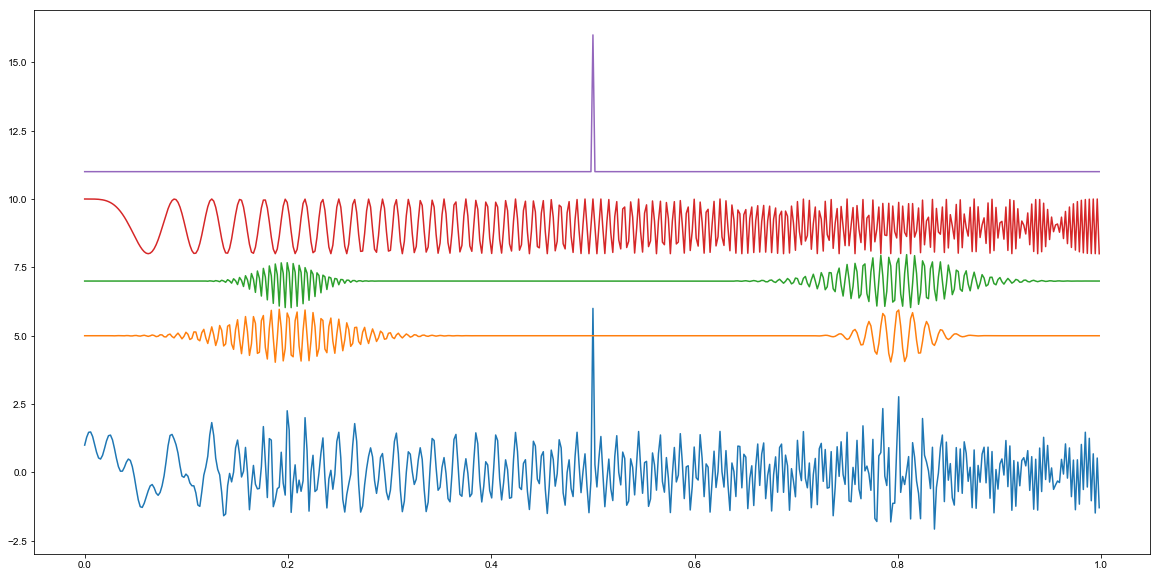

In [17]:
Fs = 512
T = 1
phi = 0
t = czas(T = 1.0, Fs = 512.0)
sig1=gabor(t0 = 0.2, sigma = 0.05, T = T, f=120, phi = phi, Fs = Fs )
sig2=gabor(t0 = 0.2, sigma = 0.025, T = T, f=170, phi = phi, Fs = Fs )
sig3 = chirp(0,256,T,Fs)
sig4=gabor(t0 = 0.8, sigma = 0.05, T = T, f=120, phi = phi, Fs = Fs )
sig5=gabor(t0 = 0.8, sigma = 0.025, T = T, f=70, phi = phi, Fs = Fs )
sig6 = 0.5*sin(f = 50.0, T =T, Fs =Fs, phi = phi)
sig7 = np.zeros(len(t))
sig7[int(len(t)/2)] = 5

sig = sig1+sig2+sig3+sig4+sig5+sig6+sig7
py.figure(figsize=(20,10))
py.plot(t, sig, 
        t, sig1+sig5 + 5,
        t, sig2+sig4 + 7,
        t, sig3 + 9,
        t, sig7 + 11)
py.show()

## Przygotowujemy sygnał do dekompozycji.
Trzeba go zapisać jako 4-bajtowy float. Gdyby dane były wielokanałowe to trzeba je przygotować w postaci multipleksowanej:

`s0ch0, s0ch1, …, s0chK, s2ch1, s2ch2, …, s2chK`

gdzie `sXchY` jest X-tą próbką w kanale Y, K jest liczbą kanałów

In [18]:
PlikSygnalu = 'test_sig.dat'
a = np.array(sig,'float32')  ##nowa macierz z float32
f = open(PlikSygnalu,'wb')
a.tofile(f)
f.close()

## Przygotowanie pliku konfiguracyjnego.
Plik ten można przygotować "ręcznie" w dowolnym edytorze tekstu. Poniżej zaprezentowane jest przygotowanie takiego pliku z poziomu `pythona`. 

Sens tych parametrów dokładniej opisany jest w: 

Rafał Kuś, Piotr T. Różański and Piotr J. Durka
"Multivariate matching pursuit in optimal Gabor dictionaries: mathematical foundations and software for EEG/MEG" BioMedical Engineering OnLine 2013 [https://biomedical-engineering-online.biomedcentral.com/articles/10.1186/1475-925X-12-94]

In [19]:
# Najpierw ustawiamy zmienne zgodnie z naszymi potrzebami

PlikSygnalu = 'test_sig.dat' # tu jeśli nie jest to plik w bieżącym katalogu 
                             # to trzeba podać pełną ścieżkę dostępu

Fs = 512.0                   # częstość próbkowania [Hz]
liczbaProbek_w_Epoce = 512   # na sztuki, istotna jeśli chcemy długi sygnał rozkładać w krótszych fragmentach, 
                             # odpowiadających np. realizacji eksperymentu
liczbaKanalow = 1            # liczba kanłów = K z powyższego opisu o 
                             # przygotowaniu sygnału
wybraneKanaly = 1            # wybrane kanały: 
                             #     a) numerowane są od 1
                             #     b) składnia wybierania: 1, 3, 5, 7-11, 19
wybraneEpoki = 1             # które epoki analizować, składnia wyboru tak jak dla kanałów
 
maxIteracji = 100            # liczba iteracji do wykonania dla jednej epoki, chyba, 
                             # że wcześniej zostanie osiągnięty zadany poniżej 
                             
procentEnergii = 95.        # procent wyjaśnionej energii
energyError    = 0.1        # parametr regulujący gęstość słownika float w zakresie 0-1. 
                            # odpowiada minimalnej odległości między atomami słownika mierzonej w metryce iloczynów skalarnych
                            # nierówności (7) w cytowanym art. 
                            # Czym mniejszy tym większy słownik i tym dokładniejsza dekompozycja 
algorytm = 'SMP'            # możliwe wartości SMP | MMP1 |MMP2 |MMP3 - algorytmy opisane w art.


# powyższe ustawiena zapisujemy do pliku tekstowego:
PlikKonfigu = 'test_sig.set'
fo = open(PlikKonfigu, "wt")
fo.write( '# OBLIGATORY PARAMETERS\n')
fo.write( 'nameOfDataFile  ' + PlikSygnalu + '\n')
fo.write( 'nameOfOutputDirectory  ./\n')
fo.write( 'writingMode            CREATE \n') # 
fo.write( 'samplingFrequency      ' + str(Fs)+ '\n')
fo.write( 'numberOfChannels       ' + str(liczbaKanalow) + '\n')
fo.write( 'selectedChannels       ' + str(wybraneKanaly) + '\n')
fo.write( 'numberOfSamplesInEpoch ' + str(liczbaProbek_w_Epoce)+ '\n')
fo.write( 'selectedEpochs         ' + str(wybraneEpoki) + '\n')
fo.write( 'typeOfDictionary       OCTAVE_FIXED\n')
fo.write( 'energyError            ' + str(energyError)+' 100.0 \n')
fo.write( 'randomSeed             auto \n')
fo.write( 'reinitDictionary       NO_REINIT_AT_ALL \n')
fo.write( 'maximalNumberOfIterations ' +str(maxIteracji)+ '\n')
fo.write( 'energyPercent             ' +str(procentEnergii)+ '\n')
fo.write( 'MP                        ' + algorytm + '\n')
fo.write( 'scaleToPeriodFactor       1.0 \n')
fo.write( 'pointsPerMicrovolt        1.0 \n')

fo.write( '\n# ADDITIONAL PARAMETERS\n')
fo.write( 'normType                  L2 \n') 
fo.write( 'diracInDictionary         YES \n') # ta i poniższe linie włączają odpowiednie typy funkcji do słownika
fo.write( 'gaussInDictionary         YES \n')
fo.write( 'sinCosInDictionary        YES \n')
fo.write( 'gaborInDictionary         YES \n')
fo.close()

## Algorytm MP: dekompozycja
Wywołujemy polecenie systemowe: ścieżka do pliku wykonywalnego MP i po spacji nazwa przygotowanego pliku z konfiguracją. Czekamy cierpliwie aż system zakończy ten proces (prawidłowe zakończenie zwraca 0).
Program empi jest dystrybuowany wraz ze SVAROGIEM (http://www.svarog.pl). Po ściągnięciu paczki (SVAROG JAR & MP binaries) w katalogu svaroga znajduje się podkatalog `mp`, a w nimi podkatalogi zawierające binaria dla konkretnych systemów operacyjnych.  Poniższe wywołanie systemowe powinno wskazywać ścieżkę dostępu do programu empi dla właściwego systemu.

In [22]:
import os
os.system('./empi-osx64 ' + PlikKonfigu)

0

## Rekonstrukcja sygnału z atomów
### Wczytanie książki
Do wczytywania książki używamy klasy zaimplementowanej w module `book_reader`, który można ściągnąć stąd https://drive.google.com/file/d/0BzwQ_Lscn8yDdS1LcDNfMmRRNTQ/view?usp=sharing

In [24]:
from book_reader import *
bookName = 'test_sig_smp.b'
book = BookImporter(bookName)

Powstały w ten sposób obiekt `book` posiada interesujące elementy:
* `book.epoch_s` - liczba punktów w epoce
* `book.fs` - częstość próbkowania
* `book.ptspmV` - w EEG - współczynnik do przeliczania wartości syg. na mikro volty
* `book.signals` - oryginalne sygnaly, z których otrzymano dekompozycję
* `book.atoms[nrumer_epoki]` - lista atomów z epoki `numer_epoki`. 
  * Atomy na tej liście są zapisane jako słowniki pythonowe z kluczem
    * `type` - typ atomu (13 -> funkcja Gabora), 
    * `params` - wartości poszczególnych parametrów

Poniższa pętla pokazuje, jak można zrekonstruoawć sygnał z parametrów przechowywanych w książce:

In [25]:
Eatoms = 0 # będziemy dla kontroli liczyć energię atomów, na początek zerujemy licznik

rekonstrukcja = np.zeros(book.epoch_s) # Przygotowujemy tablicę, w której powstanie rekonstrukcja.
t = np.arange(0,book.epoch_s/book.fs,1/book.fs) # Przygotowujemy wektor czasu. 

numerEpoki = 1                                                # Posłuży on nam do odtwarzania poszczególnych atomów
for atom in book.atoms[numerEpoki]:     # iterujemy się po atomach danej epoki
    f_Hz  = atom['params']['f']*book.fs/2    # przekodowujemy częstość atomu na częstość w Hz
    A     = atom['params']['amplitude']      # odczytujemy amplitudę
    faza  = atom['params']['phase']          # odczytujemy fazę
    t0    = atom['params']['t']/book.fs       # przeliczamy pozycję atomu z wartości w próbkach na wartości w sek.
    skala = atom['params']['scale']/book.fs   # szerokość atomu w czasie (w sek.)
    rekonstrukcja += A * np.exp(-np.pi*((t-t0)/skala)**2)*np.cos(2*np.pi*f_Hz*(t-t0)+faza) # obliczamy przebieg czasowy atomu (funkcja Gabora) i 
                                                                                            # dodajemy do rekonstrukcji
    Eatoms += atom['params']['modulus']**2 # kwadrat parametru modulus to energia niesiona przez dany atom
    

W tym momencie `rekonstrukcja` zawiera zsumowane przyczynki od wszystkich atomów w epoce wskazanej przez `numerEpoki`. Gdyby dekompozycja dotyczyła sygnału zawierającego wiele epok (np. realizacji eksperymentu) można się po nich przeiterować w następujący sposób:

In [26]:
for i, numerEpoki in enumerate(book.atoms): # iterujemy się po epokach: 
    print(i , numerEpoki)                   # w tym przykładzie pętla ta wykona się tylko raz

0 1


Wykonajmy ilustracje pokazujące otrzymaną rekonstrukcję:

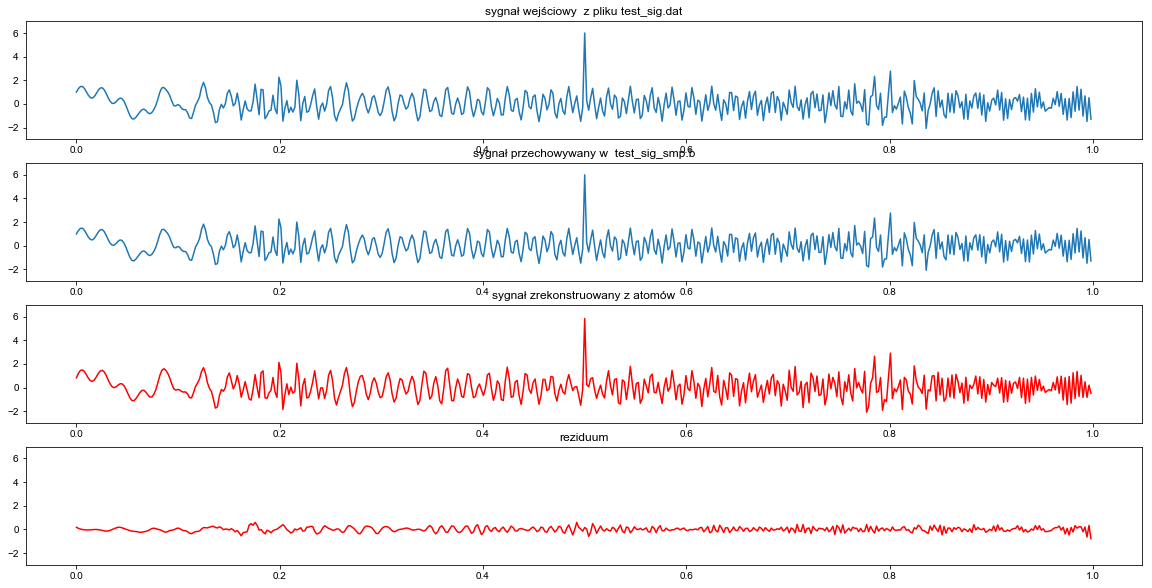

In [28]:
py.figure(figsize=(20,10))
py.subplot(411)
py.plot(t,sig)
py.ylim((-3,7))
py.title('sygnał wejściowy  z pliku test_sig.dat')
py.subplot(412)
py.plot(t,book.signals[1][0])
py.ylim((-3,7))
py.title('sygnał przechowywany w  test_sig_smp.b')
# te powyższe sygnały powinny być takie same
py.subplot(413)
py.plot(t,rekonstrukcja,'r')
py.ylim((-3,7))
py.title('sygnał zrekonstruowany z atomów')
py.subplot(414)
py.plot(t,sig - rekonstrukcja,'r')
py.ylim((-3,7))
py.title('reziduum')
py.show()

Sprawdźmy czy zachowała się energia:

In [29]:
Esignal = sum(book.signals[1][0]**2) 
print('Energia sygnału: ', np.round(Esignal,1))
print('Energia atomów: ', np.round(Eatoms,1))
print('procent wyjaśnionej energii: ', np.round(Eatoms/Esignal*100,1), '%')

Energia sygnału:  416.8
Energia atomów:  399.2
procent wyjaśnionej energii:  95.8 %


## Mapa gęstości energii
Znając prametry atomów możemy stosunkowo łatwo uzyskać reprezentacje czas-częstość. Wykonujemy ją obliczając reprezentacje poszczególnych atomów i dodając je do siebie. Formalnie można użyć w tym celu dystrybucji Wigner-Vila. 

Dzięki temu, że znamy analityczną postać funkcji opisujących poszczególne atomy możemy zastosować pewną sztuczkę. Polega ona na obliczeniu przekroju czasowego i częstotliwościowego atomu i przemnożeniu ich za pomocą iloczynu Kroneckera. Taką wersję ilustruje poniższy kod, iteracje prowadzimy analogicznie jak w przypadku rekonstrukcji czasowej:

In [30]:
bookName = 'test_sig_smp.b'
book = BookImporter(bookName)

N = int(book.fs)
Eatoms = 0
f = np.linspace(0, Fs / 2, N)
rec_t = np.zeros((1,book.epoch_s))
rec_f = np.zeros((int(book.fs),1))

mapaEnergii = np.zeros(( int(book.fs), book.epoch_s)) # Przygotowujemy tablicę, w której powstanie reprezentacja czas-częstość.
rekonstrukcja = np.zeros(book.epoch_s) # Przygotowujemy tablicę, w której powstanie rekonstrukcja.
t = np.arange(0,book.epoch_s/book.fs,1/book.fs) # Przygotowujemy wektor czasu. 
                                                # Posłuży on nam do odtwarzania poszczególnych atomów
numerEpoki = 1                                                
for atom in book.atoms[numerEpoki]:     # iterujemy się po atomach danej epoki
    f_Hz  = atom['params']['f']*book.fs/2     # przekodowujemy częstość atomu na częstość w Hz
    A     = atom['params']['amplitude']       # odczytujemy amplitudę
    faza  = atom['params']['phase']           # odczytujemy fazę
    t0    = atom['params']['t']/book.fs       # przeliczamy pozycję atomu z wartości w próbkach na wartości w sek.
    skala = atom['params']['scale']/book.fs   # szerokość atomu w czasie (w sek.)
   
    rec_t[0,:] = np.exp(-np.pi*((t-t0)/skala)**2)     # obliczamy obwiednię czasową -> dla f. Gabora jest to f. Gaussa
    rec_f[:,0] = np.exp(-np.pi*((f-f_Hz)*skala)**2)   # obliczamy obwiednię częstotliwościową -> dla f. Gabora jest to f. Gaussa
    tfr_atom = np.kron(rec_t,rec_f) # przemnażamy przez siebie obwiednie -> to jest reprezentacja czas-częstość pojedynczego atomu
    tfr_atom/= np.sum(np.sum(tfr_atom))  # normalizujemy
    tfr_atom *= atom['params']['modulus']**2 # skalujemy energię
    mapaEnergii += tfr_atom # dajemy ją do mapy 
    rekonstrukcja += A * np.exp(-np.pi*((t-t0)/skala)**2)*np.cos(2*np.pi*f_Hz*(t-t0)+faza) # obliczamy przebieg czasowy atomu (funkcja Gabora) i 

Do wyrysowania mapy możmy wykorzystać znaną nam już funkcję `TFRPlot`:

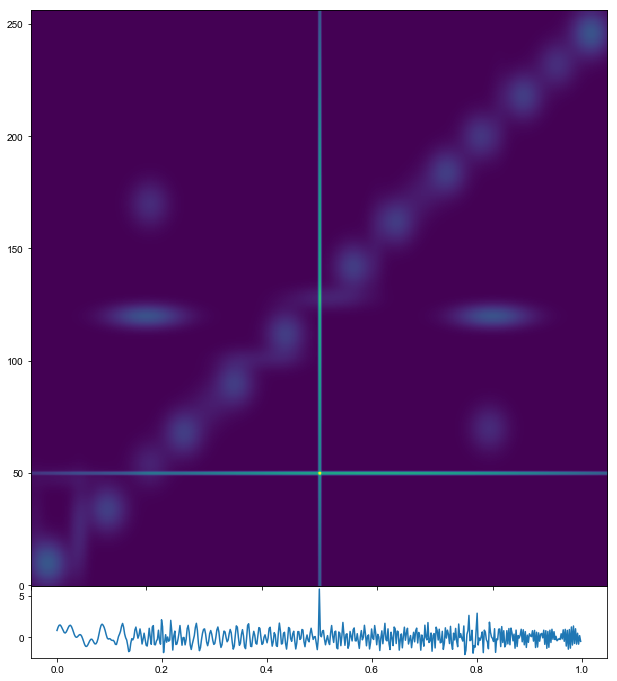

In [35]:
TFRPlot(mapaEnergii, t, f, rekonstrukcja, Fs=512,title ='') 

## Filtrowanie atomów
Do dalszych zabaw przyda nam się przepisanie wcześniejszych kodów na funkcje:

In [36]:
 def parametry_atomu(book, atom):
    f_Hz  = atom['params']['f']*book.fs/2     # przekodowujemy częstość atomu na częstość w Hz
    A     = atom['params']['amplitude']        # odczytujemy amplitudę
    faza  = atom['params']['phase']            # odczytujemy fazę
    t0    = atom['params']['t']/book.fs      # przeliczamy pozycję atomu z wartości w próbkach na wartości w sek.
    skala = atom['params']['scale']/book.fs   # szerokość atomu w czasie (w sek.)
    return f_Hz, A, faza, t0, skala  

def tfr_atomu (book, atom, N_czestosci):
    f_Hz, A, faza, t0, skala = parametry_atomu(book, atom)
    t = np.arange(0,book.epoch_s/book.fs,1/book.fs)
    f = np.linspace(0, Fs / 2, N)
    rec_t = np.zeros((1,book.epoch_s))
    rec_f = np.zeros((N_czestosci,1))
    rec_t[0,:] = np.exp(-np.pi*((t-t0)/skala)**2)      # obliczamy obwiednię czasową -> dla f. Gabora jest to f. Gaussa
    rec_f[:,0] = np.exp(-np.pi*((f-f_Hz)*skala)**2)   # obliczamy obwiednię częstotliwościową -> dla f. Gabora jest to f. Gaussa
    tfr_atom = np.kron(rec_t,rec_f) # przemnażamy przez siebie obwiednie -> to jest reprezentacja czas-częstość pojedynczego atomu
    tfr_atom/= np.sum(np.sum(tfr_atom))   # normalizujemy
    tfr_atom *= atom['params']['modulus']**2 # skalujemy energię
    return t, f, tfr_atom

def rekonstrukcja_atomu(book, atom):
    f_Hz, A, faza, t0, skala = parametry_atomu(book, atom)
    t = np.arange(0,book.epoch_s/book.fs,1/book.fs)     
    rekonstrukcja = A * np.exp(-np.pi*((t-t0)/skala)**2)*np.cos(2*np.pi*f_Hz*(t-t0)+faza) # obliczamy przebieg czasowy atomu (funkcja Gabora) i 
    return t, rekonstrukcja


### Usuwanie atomów.
Załóżmy, że sinusoida o częstości 50 Hz w naszym sygnale testowym jest niechcianym zakłuceniem pochodzącym od sieci energetycznej. Poniższy przykład pokazuje jak możemy usunąć ją z mapy i rekonstrukcji sygnału. 


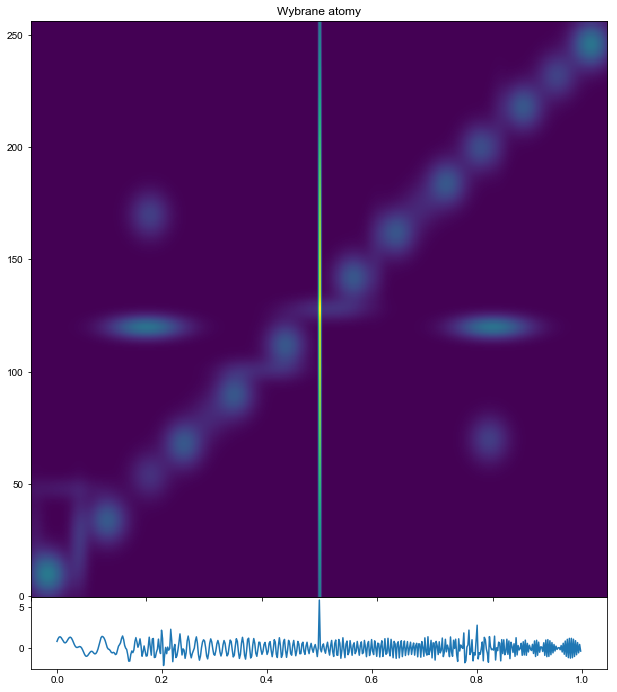

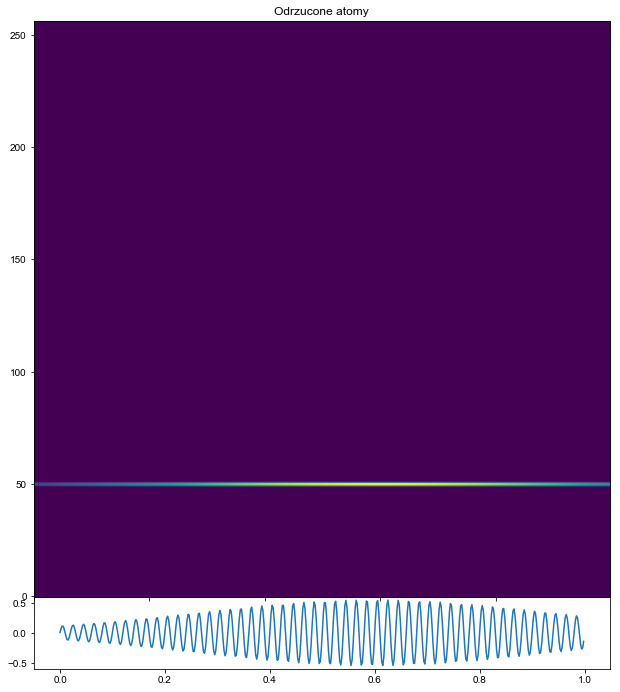

In [40]:
bookName = 'test_sig_smp.b'
book = BookImporter(bookName)
N_czestosci =512
# miejsce na rekonstrukcję atomów chcianych
rekonstrukcja_OK = np.zeros(book.epoch_s) # Przygotowujemy tablicę, w której powstanie rekonstrukcja.
mapaEnergii_OK = np.zeros(( N_czestosci, book.epoch_s)) # Przygotowujemy tablicę, w której powstanie reprezentacja czas-częstość.

# miejsce na rekonstrukcję atomów niechcianych
rekonstrukcja_RESZTA = np.zeros(book.epoch_s) #
mapaEnergii_RESZTA  = np.zeros(( N_czestosci, book.epoch_s)) # Przygotowujemy tablicę, w której powstanie reprezentacja czas-częstość.

numerEpoki = 1                                                # Posłuży on nam do odtwarzania poszczególnych atomów
for atom in book.atoms[numerEpoki]:     # iterujemy się po atomach danej epoki
    f_Hz, A, faza, t0, skala  = parametry_atomu(book, atom)
    t, atom_czas = rekonstrukcja_atomu(book, atom)
    t, f, atom_tfr = tfr_atomu (book, atom,N_czestosci)
    if f_Hz > 49.9 and f_Hz < 50.1 : # testujemy czy częstość f_Hz jest pomiędzy 49.9 a 50.1 Hz, jeśli tak to ten atom odkładamy do mapy i rekonstrukcji nieinteresujących nas 
        mapaEnergii_RESZTA += atom_tfr
        rekonstrukcja_RESZTA += atom_czas    
    else:        # jeśli atom nie spełnieł powyższego warunku, to znaczy że jest OK i chcemy go uwzgędnić w mapie i rekonstrukcji 
        mapaEnergii_OK += atom_tfr
        rekonstrukcja_OK += atom_czas
        
TFRPlot(mapaEnergii_OK, t, f, rekonstrukcja_OK, Fs=512,title ='Wybrane atomy') 
TFRPlot(mapaEnergii_RESZTA, t, f, rekonstrukcja_RESZTA, Fs=512,title ='Odrzucone atomy') 



### Zadanie: proszę usunąć z rekonstrukcji atomy należące do chirpa.
Wskazówka: znaleźć równanie chirpa jako f(t). Atomy, których parametry `t_0` i `f_Hz` spełniją to równanie (z pweną dokładnością) należy odrzucić.

0.0


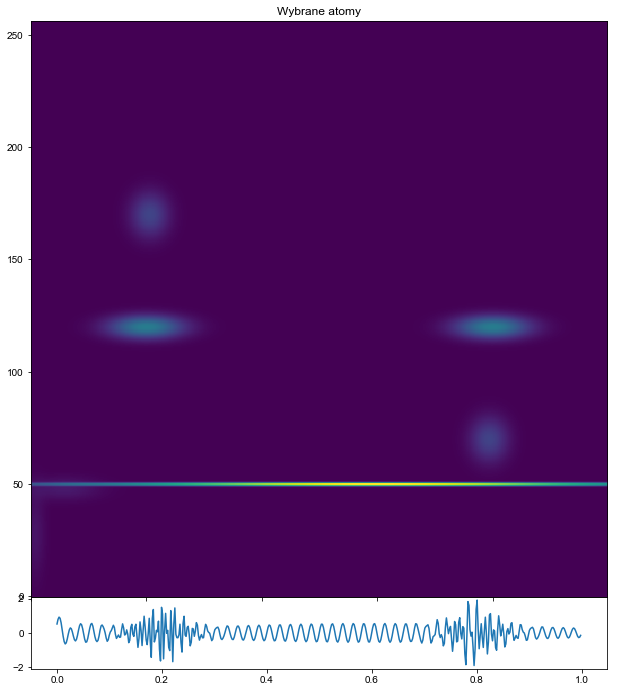

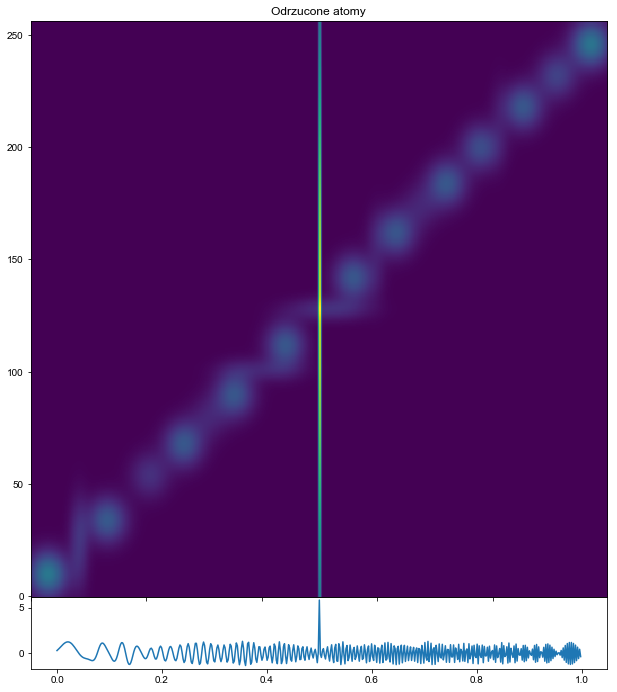

In [87]:
chirp_f  = lambda t: 512/2*t
print(chirp_f(0))

bookName = 'test_sig_smp.b'
book = BookImporter(bookName)
N_czestosci =512
# miejsce na rekonstrukcję atomów chcianych
rekonstrukcja_OK = np.zeros(book.epoch_s) # Przygotowujemy tablicę, w której powstanie rekonstrukcja.
mapaEnergii_OK = np.zeros(( N_czestosci, book.epoch_s)) # Przygotowujemy tablicę, w której powstanie reprezentacja czas-częstość.

# miejsce na rekonstrukcję atomów niechcianych
rekonstrukcja_RESZTA = np.zeros(book.epoch_s) #
mapaEnergii_RESZTA  = np.zeros(( N_czestosci, book.epoch_s)) # Przygotowujemy tablicę, w której powstanie reprezentacja czas-częstość.

numerEpoki = 1                                                # Posłuży on nam do odtwarzania poszczególnych atomów
for atom in book.atoms[numerEpoki]:     # iterujemy się po atomach danej epoki
    f_Hz, A, faza, t0, skala  = parametry_atomu(book, atom)
    t, atom_czas = rekonstrukcja_atomu(book, atom)
    t, f, atom_tfr = tfr_atomu (book, atom,N_czestosci)
    if f_Hz > chirp_f(t0)-5 and f_Hz < chirp_f(t0)+5: # testujemy czy częstość f_Hz jest pomiędzy 49.9 a 50.1 Hz, jeśli tak to ten atom odkładamy do mapy i rekonstrukcji nieinteresujących nas 
        mapaEnergii_RESZTA += atom_tfr
        rekonstrukcja_RESZTA += atom_czas    
    else:        # jeśli atom nie spełnieł powyższego warunku, to znaczy że jest OK i chcemy go uwzgędnić w mapie i rekonstrukcji 
        mapaEnergii_OK += atom_tfr
        rekonstrukcja_OK += atom_czas
        
TFRPlot(mapaEnergii_OK, t, f, rekonstrukcja_OK, Fs=512,title ='Wybrane atomy') 
TFRPlot(mapaEnergii_RESZTA, t, f, rekonstrukcja_RESZTA, Fs=512,title ='Odrzucone atomy') 

## Zadanie: składka EEG
W tm zadaniu proszę:
* zdekomponować znaną już nam składkę sygnału EEG `c4spin.txt`, używając 50 iteracji słownika o parametrze `energyError = 0.01`
* uzyskać jej mapę czas-częstość z atomów MP 
* uzyskać wykresy (wykreślone za pomocą '*') zależności:
  * energii atomu od numeru iteracji
  * energii atomu od jego częstości
  * amplitudę od  skali 
  * przy `*` dopisać numer atomu
  * podać parametry atomu nr 3

Przygotuj sygnał w postaci pliku binarnego z 4-bajtowymi floatami:

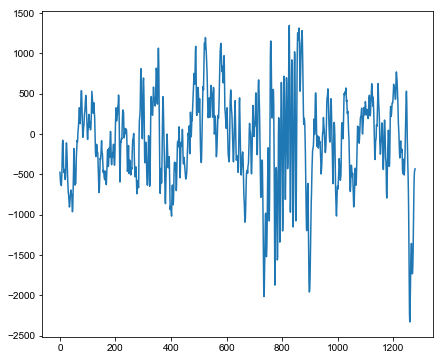

In [102]:
s = np.loadtxt('c4spin.txt')
PlikSygnalu = 'c4spin.dat'
a = np.array(s,'float32')  ##nowa macierz z float32
f = open(PlikSygnalu,'wb')
a.tofile(f)
f.close()
py.plot(a)

Przygotuj plik konfiguracyjny. Chcemy:
* wykonać 30 itereacji, 
* błąd energii 0.05 

In [123]:
PlikKonfigu = 'c4spin.set'
PlikSygnalu = 'c4spin.dat'
Fs = 128
liczbaProbek_w_Epoce = len(s)
liczbaKanalow = 1
wybraneKanaly = 1
wybraneEpoki = 1
typSlownika = 'OCTAVE_FIXED'
maxIteracji = 100
procentEnergii = 95.
energyError    = 0.05
algorytm = 'SMP'

fo = open(PlikKonfigu, "wt")
fo.write( '# OBLIGATORY PARAMETERS\n')
fo.write( 'nameOfDataFile  ' + PlikSygnalu + '\n')
fo.write( 'nameOfOutputDirectory  ./\n')
fo.write( 'writingMode            CREATE \n') # 
fo.write( 'samplingFrequency      ' + str(Fs)+ '\n')
fo.write( 'numberOfChannels       ' + str(liczbaKanalow) + '\n')
fo.write( 'selectedChannels       ' + str(wybraneKanaly) + '\n')
fo.write( 'numberOfSamplesInEpoch ' + str(liczbaProbek_w_Epoce)+ '\n')
fo.write( 'selectedEpochs         ' + str(wybraneEpoki) + '\n')
fo.write( 'typeOfDictionary       ' + typSlownika +'\n')
fo.write( 'energyError            0.05 100.0 \n')
fo.write( 'randomSeed             auto \n')
fo.write( 'reinitDictionary       NO_REINIT_AT_ALL \n')
fo.write( 'maximalNumberOfIterations ' +str(maxIteracji)+ '\n')
fo.write( 'energyPercent             ' +str(procentEnergii)+ '\n')
fo.write( 'MP                        ' + algorytm + '\n')
fo.write( 'scaleToPeriodFactor       1.0 \n')
fo.write( 'pointsPerMicrovolt        1.0 \n')

fo.write( '\n# ADDITIONAL PARAMETERS\n')
fo.write( 'normType                  L2 \n')
fo.write( 'diracInDictionary         YES \n')
fo.write( 'gaussInDictionary         YES \n')
fo.write( 'sinCosInDictionary        YES \n')
fo.write( 'gaborInDictionary         YES \n')
fo.write( 'progressBar               YES \n')
fo.close()

In [124]:
os.system('./empi-osx64 ' + PlikKonfigu)

0

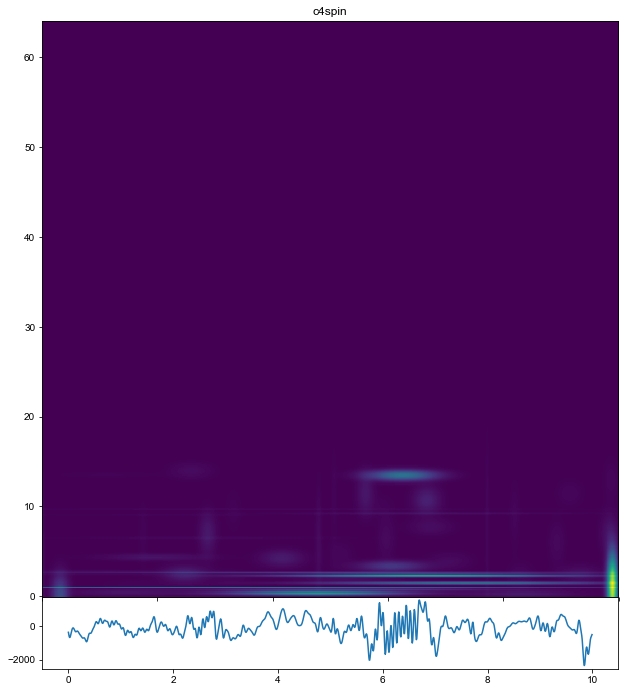

In [127]:
bookName = 'c4spin_smp.b'
book = BookImporter(bookName)
rekonstrukcja = np.zeros(book.epoch_s) # Przygotowujemy tablicę, w której powstanie rekonstrukcja.
N_czestosci = 512
mapaEnergii = np.zeros(( N_czestosci, book.epoch_s )) # Przygotowujemy tablicę, w której powstanie reprezentacja czas-częstość.
numerEpoki = 1                                                # Posłuży on nam do odtwarzania poszczególnych atomów

for atom in book.atoms[numerEpoki]:     # iterujemy się po atomach danej epoki
    f_Hz, A, faza, t0, skala  = parametry_atomu(book, atom)
    t, atom_czas = rekonstrukcja_atomu(book, atom)
    t, f, atom_tfr = tfr_atomu (book, atom,N_czestosci)
    mapaEnergii += atom_tfr
    rekonstrukcja += atom_czas   
TFRPlot(mapaEnergii, t, f, rekonstrukcja, Fs=128,title ='c4spin') 



Wykresy zależności:
* energii atomu od numeru iteracji
* energii atomu od jego częstości
* amplitudę od skali
* przy * dopisać numer atomu

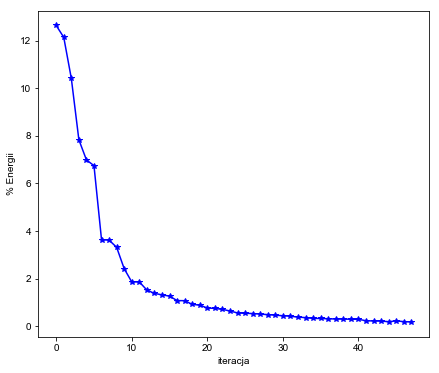

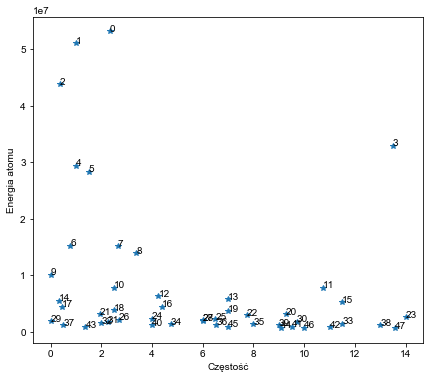

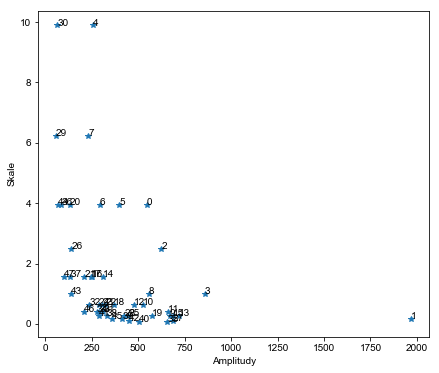

In [132]:
bookName = 'c4spin_smp.b'
book = BookImporter(bookName)

energie =    []
czestosci = []
amplitudy = []
skale = []
czasy = []

mapaEnergii = np.zeros(( int(book.fs), book.epoch_s))
for atom in book.atoms[1]:
    f_Hz, A, faza, t0, skala  = parametry_atomu(book, atom)
    czestosci.append(f_Hz)
    amplitudy.append(A)
    skale.append(skala)
    czasy.append(t0)
    energie.append(atom['params']['modulus']**2)

# plotting
E_syg = np.sum(book.signals[1][0]**2)
py.plot(energie/E_syg * 100,'b*-')
py.ylabel('% Energii')
py.xlabel('iteracja')
py.show()

py.plot(czestosci,energie,'*')
for i, f_i in enumerate(czestosci):
    py.text(f_i,energie[i], str(i))
py.ylabel('Energia atomu')
py.xlabel('Częstość')
py.show()

py.plot(amplitudy, skale,'*')
for i, a_i in enumerate(amplitudy):
    py.text(a_i,skale[i], str(i))
py.ylabel('Skale')
py.xlabel('Amplitudy')
py.show()

Podać parametry atomu nr 3

In [41]:
print('Atom nr 3 - pozycja: ',np.round(czasy[3],2),' częstość' ,np.round(...), 'Hz', 'skala: '  ,np.round(...), 's')

Atom nr 3 - pozycja:  6.25  częstość 13.5 Hz skala:  0.99 s


Utwórz symulację zawierającą 4 funkcje gabora (tak jak w pierwszym sygnale testowym).
Wykonaj dekompozycję na 6 iteracji. Zmieniaj parametr `energyError` $\in\{0.1, 0.05, 0.01\}$.  Wypisz parametry atomów i porównaj z parametrami struktur w symulacji: